**Rozdział 13. Splotowe sieci neuronowe**

_Notatnik ten zawiera przykładowy kod i rozwiązania ćwiczeń opisane w rozdziale 13._

# Konfiguracja

Upewnijmy się najpierw, że notatnik ten będzie działał w środowiskach Python 2 i 3, importujmy kilka powszechnie stosowanych modułów, upewnijmy się, że moduł MatplotLib będzie prawidłowo tworzył wykresy, a także przygotujmy funkcję zapisującą rysunki:

In [1]:
# Obsługa środowisk Python 2 i Python 3
from __future__ import division, print_function, unicode_literals

# Importowanie popularnych modułów
import numpy as np
import os

# W celu zachowania powtarzalności wyników w kolejnych przebiegach
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# Generowanie ładnych wykresów
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Lokacja, w której będą zapisywane rysunki
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "rysunki", CHAPTER_ID, fig_id + ".png")
    print("Zapisywanie rysunku", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Dwie funkcje służące do tworzenia wykresów obrazów w skali szarości oraz w kanałach RGB:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

Oczywiście, będziemy potrzebować również modułu TensorFlow:

In [3]:
import tensorflow as tf

# Warstwa splotowa

In [4]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
image = china[150:220, 130:250]
height, width, channels = image.shape
image_grayscale = image.mean(axis=2).astype(np.float32)
images = image_grayscale.reshape(1, height, width, 1)

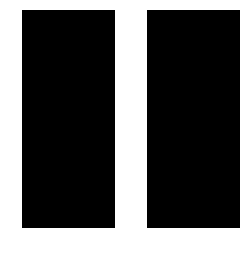

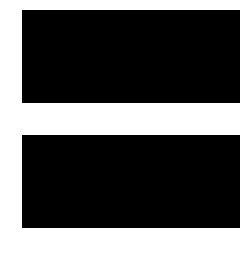

In [5]:
fmap = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)
fmap[:, 3, 0, 0] = 1
fmap[3, :, 0, 1] = 1
plot_image(fmap[:, :, 0, 0])
plt.show()
plot_image(fmap[:, :, 0, 1])
plt.show()

In [6]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, height, width, 1))
feature_maps = tf.constant(fmap)
convolution = tf.nn.conv2d(X, feature_maps, strides=[1,1,1,1], padding="SAME")

In [7]:
with tf.Session() as sess:
    output = convolution.eval(feed_dict={X: images})

Zapisywanie rysunku Chiny_oryginał


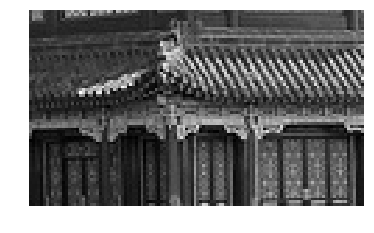

In [9]:
plot_image(images[0, :, :, 0])
save_fig("Chiny_oryginał", tight_layout=False)
plt.show()

Zapisywanie rysunku Chiny_pionowo


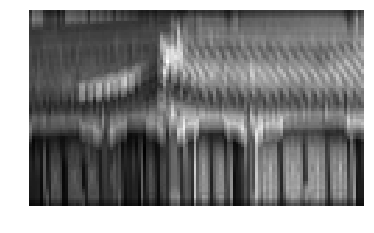

In [10]:
plot_image(output[0, :, :, 0])
save_fig("Chiny_pionowo", tight_layout=False)
plt.show()

Zapisywanie rysunku Chiny_poziomo


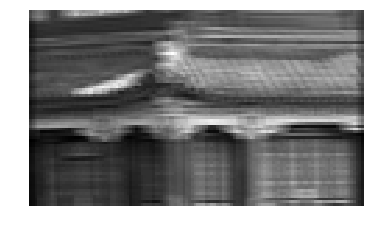

In [11]:
plot_image(output[0, :, :, 1])
save_fig("Chiny_poziomo", tight_layout=False)
plt.show()

## Prosty przykład

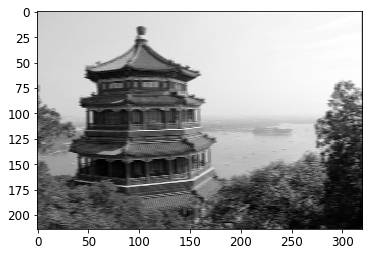

In [12]:
import numpy as np
from sklearn.datasets import load_sample_images

# Wczytuje przykładowe obrazy
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
dataset = np.array([china, flower], dtype=np.float32)
batch_size, height, width, channels = dataset.shape

# Tworzy dwa filtry
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # linia pionowa
filters[3, :, :, 1] = 1  # linia pozioma

# Tworzy graf zawierający wejście X oraz warstwę splotową wykorzystującą dwa filtry 
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
convolution = tf.nn.conv2d(X, filters, strides=[1,2,2,1], padding="SAME")

with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X: dataset})

plt.imshow(output[0, :, :, 1], cmap="gray") # rysuje wykres drugiej mapy cech dla pierwszego rysunku
plt.show()

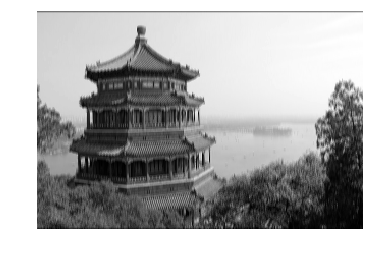

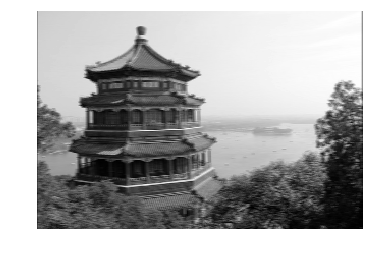

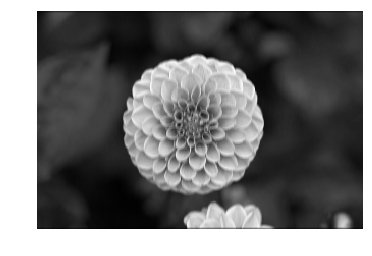

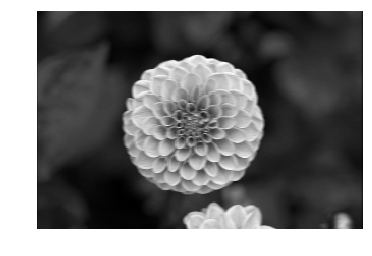

In [13]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plot_image(output[image_index, :, :, feature_map_index])
        plt.show()

Zastosowanie funkcji `tf.layers.conv2d()`:

In [14]:
reset_graph()

X = tf.placeholder(shape=(None, height, width, channels), dtype=tf.float32)
conv = tf.layers.conv2d(X, filters=2, kernel_size=7, strides=[2,2],
                        padding="SAME")

In [15]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    output = sess.run(conv, feed_dict={X: dataset})

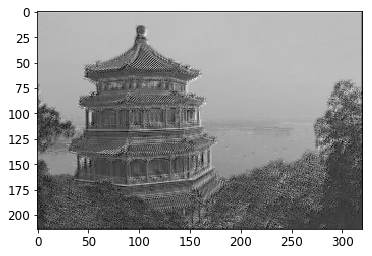

In [16]:
plt.imshow(output[0, :, :, 1], cmap="gray") # rysuje wykres drugiej mapy cech dla pierwszego rysunku
plt.show()

## Uzupełnianie zerami typu VALID i SAME

In [17]:
reset_graph()

filter_primes = np.array([2., 3., 5., 7., 11., 13.], dtype=np.float32)
x = tf.constant(np.arange(1, 13+1, dtype=np.float32).reshape([1, 1, 13, 1]))
filters = tf.constant(filter_primes.reshape(1, 6, 1, 1))

valid_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='VALID')
same_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='SAME')

with tf.Session() as sess:
    print("VALID:\n", valid_conv.eval())
    print("SAME:\n", same_conv.eval())

VALID:
 [[[[ 184.]
   [ 389.]]]]
SAME:
 [[[[ 143.]
   [ 348.]
   [ 204.]]]]


In [18]:
print("VALID:")
print(np.array([1,2,3,4,5,6]).T.dot(filter_primes))
print(np.array([6,7,8,9,10,11]).T.dot(filter_primes))
print("SAME:")
print(np.array([0,1,2,3,4,5]).T.dot(filter_primes))
print(np.array([5,6,7,8,9,10]).T.dot(filter_primes))
print(np.array([10,11,12,13,0,0]).T.dot(filter_primes))


VALID:
184.0
389.0
SAME:
143.0
348.0
204.0


# Warstwa buforowa

In [19]:
batch_size, height, width, channels = dataset.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # linia pionowa
filters[3, :, :, 1] = 1  # linia pozioma

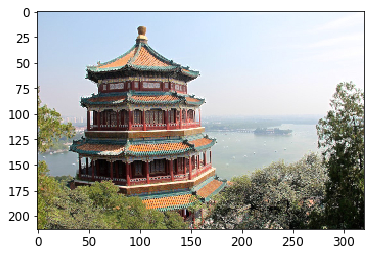

In [20]:
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
max_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1],padding="VALID")

with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict={X: dataset})

plt.imshow(output[0].astype(np.uint8))  # rysuje wykres dla pierwszego rysunku
plt.show()

Zapisywanie rysunku Chiny_oryginał


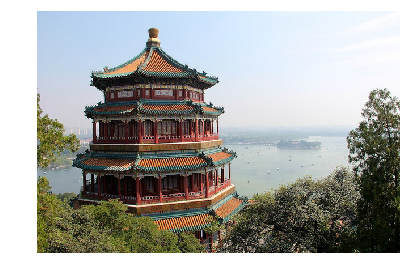

Zapisywanie rysunku Chiny_maksymalizująca_buforowa


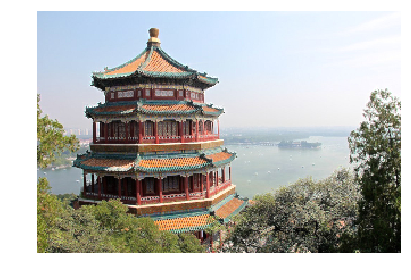

In [21]:
plot_color_image(dataset[0])
save_fig("Chiny_oryginał")
plt.show()
    
plot_color_image(output[0])
save_fig("Chiny_maksymalizująca_buforowa")
plt.show()

# Zestaw danych MNIST

Uwaga: w książce były używane funkcje `fully_connected()`, `conv2d()` i `dropout()` stanowiące część modułu `tensorflow.contrib.layers`, tutaj natomiast wykorzystujemy ich odpowiedniki (funkcje `dense()`, `conv2d()` i `dropout()`) z modułu `tf.layers`, który nie istniał w trakcie pisania rozdziału. Jest to zalecane rozwiązanie, ponieważ wszelkie elemnty modułu `contrib` mogą być modyfikowane lub usuwane bez uprzedzenia, natomiast moduł `tf.layers` jest częścią oficjalnego interfejsu API. Jak się niebawem przekonamy, stosowany przez nas kod pozostaje w większości niezmieniony.

W przypadku wszystkich wymienionych funkcji:
* parametr `scope` został przemianowany na `name`, natomiast ze wszystkich parametrów mających przyrostek `_fn` został on usunięty (np. parametr `activation_fn` nosi teraz nazwę `activation`).

Najważniejsze różnice w funkcji `tf.layers.dense()`:
* parametr `weights` nosi teraz nazwę `kernel` (a zmienna wag została przemianowana na `"kernel"` z nazwy `"weights"`),
* domyślna wartość aktywacji to `None`, a nie `tf.nn.relu`.

Najważniejsze różnice w funkcji `tf.layers.conv2d()`:
* parametr `num_outputs` został przemianowany na `filters`,
* parametr `stride` został przemianowany na `strides`,
* domyślna wartość aktywacji to `None`, a nie `tf.nn.relu`.

Najważniejsze różnice w funkcji `tf.layers.dropout()`:
* wykorzystuje współczynnik porzucania (`rate`) zamiast prawdopodobieństwa zatrzymania (`keep_prob`). Oczywiście `rate == 1 - keep_prob`,
* parametr `is_training` został przemianowany na `training`.

In [22]:
height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 10

reset_graph()

with tf.name_scope("wejscia"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="splot1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="splot2")

with tf.name_scope("bufor3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])

with tf.name_scope("pp1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="pp1")

with tf.name_scope("wyjscie"):
    logits = tf.layers.dense(fc1, n_outputs, name="wyjscie")
    Y_proba = tf.nn.softmax(logits, name="Y_prawd")

with tf.name_scope("uczenie"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("ocena"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("inicjacja_i_zapis"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

Uwaga: jeśli korzystasz ze środowiska Python 3.6 na systemie OSX, musisz wpisać poniższe polecenie w terminalu, aby zainstalować pakiet certyfikatów `certifi`, ponieważ środowisko Python 3.6 na systemie OSX nie zawiera certyfikatów uwierzytelniających połączenia SSL (patrz następujące [pytanie w serwisie StackOverflow](https://stackoverflow.com/questions/27835619/urllib-and-ssl-certificate-verify-failed-error)):

    $ /Applications/Python\ 3.6/Install\ Certificates.command

In [23]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/dane/")

Extracting /tmp/dane/train-images-idx3-ubyte.gz
Extracting /tmp/dane/train-labels-idx1-ubyte.gz
Extracting /tmp/dane/t10k-images-idx3-ubyte.gz
Extracting /tmp/dane/t10k-labels-idx1-ubyte.gz


In [24]:
n_epochs = 10
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Dokładność dla: zbioru uczącego:", acc_train, "Zbioru testowego:", acc_test)

        save_path = saver.save(sess, "./moj_model_mnist")

0 Dokładność dla: zbioru uczącego: 0.99 Zbioru testowego: 0.9763
1 Dokładność dla: zbioru uczącego: 0.99 Zbioru testowego: 0.9801
2 Dokładność dla: zbioru uczącego: 0.97 Zbioru testowego: 0.9836
3 Dokładność dla: zbioru uczącego: 0.99 Zbioru testowego: 0.9873
4 Dokładność dla: zbioru uczącego: 1.0 Zbioru testowego: 0.9884
5 Dokładność dla: zbioru uczącego: 0.97 Zbioru testowego: 0.9897
6 Dokładność dla: zbioru uczącego: 1.0 Zbioru testowego: 0.9901
7 Dokładność dla: zbioru uczącego: 0.99 Zbioru testowego: 0.9899
8 Dokładność dla: zbioru uczącego: 1.0 Zbioru testowego: 0.9893
9 Dokładność dla: zbioru uczącego: 1.0 Zbioru testowego: 0.9889


# Rozwiązania ćwiczeń

## 1. do 6.

Patrz dodatek A.

## 7. Sieć splotowa dużej dokładności dla zbioru MNIST
Ćwiczenie: Stwórz własną sieć CNN i spróbuj osiągnąć jak największą dokładność wobec zbioru danych MNIST.

Poniższa sieć CNN przypomina architekturę zdefiniowaną powyżej, jedyne różnice to rozmiar kroku równy 1 (zamiast 2) w drugiej warstwie splotowej, porzucanie o wartości 25% po drugiej warstwie splotowej, porzucanie o wartości 50% po w pełni połączonej warstwie, a także wykorzystanie wczesnego zatrzymywania podczas uczenia. Osiąga dokładność rzędu 99,2% dla zestawu MNIST. Nie jest to żaden cud świata, ale również nie jest to zły wynik. Jesteś w stanie osiągnąć lepszy rezultat?

In [25]:
import tensorflow as tf

height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 1
conv2_pad = "SAME"
conv2_dropout_rate = 0.25

pool3_fmaps = conv2_fmaps

n_fc1 = 128
fc1_dropout_rate = 0.5

n_outputs = 10

reset_graph()

with tf.name_scope("wejscia"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='uczenie')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="splot1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="splot2")

with tf.name_scope("bufor3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 14 * 14])
    pool3_flat_drop = tf.layers.dropout(pool3_flat, conv2_dropout_rate, training=training)

with tf.name_scope("pp1"):
    fc1 = tf.layers.dense(pool3_flat_drop, n_fc1, activation=tf.nn.relu, name="pp1")
    fc1_drop = tf.layers.dropout(fc1, fc1_dropout_rate, training=training)

with tf.name_scope("wyjscie"):
    logits = tf.layers.dense(fc1, n_outputs, name="wyjscie")
    Y_proba = tf.nn.softmax(logits, name="Y_prawd")

with tf.name_scope("uczenie"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("ocena"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("inicjacja_i_zapisywanie"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

Wczytajmy dane:

In [26]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/dane/")

Extracting /tmp/dane/train-images-idx3-ubyte.gz
Extracting /tmp/dane/train-labels-idx1-ubyte.gz
Extracting /tmp/dane/t10k-images-idx3-ubyte.gz
Extracting /tmp/dane/t10k-labels-idx1-ubyte.gz


Funkcja `get_model_params()` pobiera stan modelu (tj. wartości wszystkich zmiennych), natomiast funkcja `restore_model_params()` odtwarza poprzedni stan. Służą one do przyśpieszania procesu wczesnego zatrzymywania: najlepszy model nie musi być zapisywany na dysku, lecz jest przechowywany w pamięci operacyjnej. Na końcu procesu uczenia cofamy się do najlepszego znalezionego modelu.

In [27]:
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

Wytrenujmy w końcu nasz model! Poniższa implementacja wczesnego zatrzymywania działa następująco:
* co 100 przebiegów uczących model jest oceniany wobec zbioru walidacyjnego,
* jeśli dany model spisuje się lepiej od dotychczas znalezionego najlepszego modelu, to zostaje zapisany w pamięci RAM,
* jeśli nie masz żadnych postępów przez 100 przebiegów z rzędu, to proces uczenia zostaje przerwany,
* po zakończeniu procesu uczenia zostaje odtworzony najlepszy znaleziony model.

In [30]:
n_epochs = 1000
batch_size = 50

best_loss_val = np.infty
check_interval = 500
checks_since_last_progress = 0
max_checks_without_progress = 20
best_model_params = None 

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
            if iteration % check_interval == 0:
                loss_val = loss.eval(feed_dict={X: mnist.validation.images,
                                                y: mnist.validation.labels})
                if loss_val < best_loss_val:
                    best_loss_val = loss_val
                    checks_since_last_progress = 0
                    best_model_params = get_model_params()
                else:
                    checks_since_last_progress += 1
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: mnist.validation.images,
                                           y: mnist.validation.labels})
        print("Epoka {}, dokładność dla zb. uczącego {:.4f}%, walidacyjnego: {:.4f}%, najlepsza strata dla zb. walidacyjnego: {:.6f}".format(
                  epoch, acc_train * 100, acc_val * 100, best_loss_val))
        if checks_since_last_progress > max_checks_without_progress:
            print("Wczesne zatrzymywanie!")
            break

    if best_model_params:
        restore_model_params(best_model_params)
    acc_test = accuracy.eval(feed_dict={X: mnist.test.images,
                                        y: mnist.test.labels})
    print("Ostateczna dokładność dla zbioru testowego:", acc_test)
    save_path = saver.save(sess, "./moj_model_mnist")

Epoka 0, dokładność dla zb. uczącego 100.0000%, walidacyjnego: 98.4600%, najlepsza strata dla zb. walidacyjnego: 0.053476
Epoka 1, dokładność dla zb. uczącego 100.0000%, walidacyjnego: 98.7200%, najlepsza strata dla zb. walidacyjnego: 0.045855
Epoka 2, dokładność dla zb. uczącego 100.0000%, walidacyjnego: 99.0000%, najlepsza strata dla zb. walidacyjnego: 0.039129
Epoka 3, dokładność dla zb. uczącego 100.0000%, walidacyjnego: 98.7600%, najlepsza strata dla zb. walidacyjnego: 0.035295
Epoka 4, dokładność dla zb. uczącego 100.0000%, walidacyjnego: 99.1400%, najlepsza strata dla zb. walidacyjnego: 0.035295
Epoka 5, dokładność dla zb. uczącego 100.0000%, walidacyjnego: 98.9400%, najlepsza strata dla zb. walidacyjnego: 0.035295
Epoka 6, dokładność dla zb. uczącego 100.0000%, walidacyjnego: 99.1800%, najlepsza strata dla zb. walidacyjnego: 0.035295
Epoka 7, dokładność dla zb. uczącego 100.0000%, walidacyjnego: 98.9800%, najlepsza strata dla zb. walidacyjnego: 0.033638
Epoka 8, dokładność dla 

## 8.  Klasyfikowanie dużych obrazów za pomocą sieci Inception v3

### 8.1.
Ćwiczenie: Pobierz zdjęcia różnych zwierząt. Wczytaj je do środowiska Python, na przykład za pomocą funkcji `matplotlib.image.mpimg.imread()` lub `scipy.misc.imread()`. Zmień ich rozmiar lub przytnij je do rozmiaru 299 × 299 pikseli i upewnij się, że wszystkie mają trzy kanały (RGB) i nie zawierają kanału przezroczystości.

In [31]:
width = 299
height = 299
channels = 3

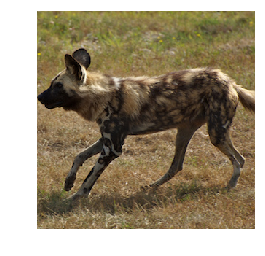

In [32]:
import matplotlib.image as mpimg
test_image = mpimg.imread(os.path.join("rysunki","cnn","obraz_testowy.png"))[:, :, :channels]
plt.imshow(test_image)
plt.axis("off")
plt.show()

Upewnijmy się, że wartości mieszczą się w zakresie [-1, 1] (zgodnie z wymaganiami gotowego modelu Inception), a nie [0, 1]:

In [33]:
test_image = 2 * test_image - 1

## 8.2.
Ćwiczenie: pobierz najnowszy wytrenowany model architektury Inception v3: punkt kontrolny jest dostępny pod adresem  https://github.com/tensorflow/models/tree/master/research/slim. Listę nazw klas znajdziemy pod adresem https://goo.gl/brXRtZ, ale musimy na początku wstawić klasę `background`.


In [34]:
import sys
import tarfile
from six.moves import urllib

TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("zestawy danych", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rPobieranie: {}%".format(percent))
    sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "inception_v3.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)

In [35]:
fetch_pretrained_inception_v3()

Pobieranie: 100%

In [36]:
import re

CLASS_NAME_REGEX = re.compile(r"^n\d+\s+(.*)\s*$", re.M | re.U)

def load_class_names():
    with open(os.path.join("zestawy danych", "inception", "imagenet_class_names.txt"), "rb") as f:
        content = f.read().decode("utf-8")
        return CLASS_NAME_REGEX.findall(content)

In [37]:
class_names = ["background"] + load_class_names()

In [38]:
class_names[:5]

['background',
 'tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri']

## 8.3.
Ćwiczenie: stwórz model Inception v3 wywołując funkcję `inception_v3()` tak, jak zaprezentowałem w poniższym fragmencie kodu. Należy tego dokonać w zakresie argumentów stworzonym przez funkcję `inception_v3_arg_scope()` Poza tym musimy wprowadzić parametry `is_training=False` i `num_classes=1001` [...]

In [40]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

reset_graph()

X = tf.placeholder(tf.float32, shape=[None, 299, 299, 3], name="X")
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(
        X, num_classes=1001, is_training=False)
predictions = end_points["Predictions"]
saver = tf.train.Saver()

### 8.4.
Ćwiczenie: otwórz sesję i użyj węzła `Saver` do wczytania pobranego punktu kontrolnego.


In [41]:
with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    # ...

INFO:tensorflow:Restoring parameters from zestawy danych\inception\inception_v3.ckpt


### 8.5.
Ćwiczenie: Wykorzystaj ten model do klasyfikowania przygotowanych obrazów. Wyświetl pięć najlepszych prognoz dla każdego obrazu wraz z oszacowanym prawdopodobieństwem jego przynależności do klasy (lista nazw klas jest dostępna na stronie https://goo.gl/brXRtZ). Jaką dokładność uzyskuje model?


In [42]:
X_test = test_image.reshape(-1, height, width, channels)

with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    predictions_val = predictions.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from zestawy danych\inception\inception_v3.ckpt


In [43]:
most_likely_class_index = np.argmax(predictions_val[0])
most_likely_class_index

276

In [44]:
class_names[most_likely_class_index]

'African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus'

In [45]:
top_5 = np.argpartition(predictions_val[0], -5)[-5:]
top_5 = reversed(top_5[np.argsort(predictions_val[0][top_5])])
for i in top_5:
    print("{0}: {1:.2f}%".format(class_names[i], 100 * predictions_val[0][i]))

African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus: 93.13%
hyena, hyaena: 2.57%
European fire salamander, Salamandra salamandra: 0.06%
bearskin, busby, shako: 0.05%
swimming trunks, bathing trunks: 0.05%


Model jest dość dokładny wobec tego konkretnego zdjęcia: uzyskuje prawidłową prognozę z dużą dozą pewności.

## 9. 9.	Uczenie transferowanie w zadaniach klasyfikacji dużych obrazów

### 9.1.
Ćwiczenie: a.	Stwórz zestaw uczący składający się przynajmniej ze 100 obrazów na każdą klasę. Przykładowo możesz klasyfikować własne zdjęcie pod względem lokalizacji (plaża, góry, miasto itd.) lub ewentualnie skorzystaj z istniejącego zbioru danych, takiego jak zestawy [zdjęć kwiatów](https://goo.gl/EgJVXZ) lub [miejsc](http://places.csail.mit.edu/) z których ten drugi jest udostępniony uniwersytet MIT (wymagana jest rejestracja, a sam zestaw danych jest pokaźnych rozmiarów).


Pobawmy się zbiorem zdjęć kwiatów. Najpierw musimy go pobrać:

In [46]:
import sys
import tarfile
from six.moves import urllib

FLOWERS_URL = "http://download.tensorflow.org/example_images/flower_photos.tgz"
FLOWERS_PATH = os.path.join("zestawy danych", "kwiaty")

def fetch_flowers(url=FLOWERS_URL, path=FLOWERS_PATH):
    if os.path.exists(FLOWERS_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "flower_photos.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    flowers_tgz = tarfile.open(tgz_path)
    flowers_tgz.extractall(path=path)
    flowers_tgz.close()
    os.remove(tgz_path)

In [47]:
fetch_flowers()

Pobieranie: 100%

Każdy podkatalog folderu `flower_photos` zawiera wszystkie zdjęcia danej klasy. Pobierzmy listę klas:

In [48]:
flowers_root_path = os.path.join(FLOWERS_PATH, "flower_photos")
flower_classes = sorted([dirname for dirname in os.listdir(flowers_root_path)
                  if os.path.isdir(os.path.join(flowers_root_path, dirname))])
flower_classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

Pobierzmy listę wszystkich ścieżek obrazów dla każdej klasy:

In [49]:
from collections import defaultdict

image_paths = defaultdict(list)

for flower_class in flower_classes:
    image_dir = os.path.join(flowers_root_path, flower_class)
    for filepath in os.listdir(image_dir):
        if filepath.endswith(".jpg"):
            image_paths[flower_class].append(os.path.join(image_dir, filepath))

Uporządkujmy ścieżki do obrazów po to, aby kod w notatniku dawał powtarzalne wyniki w przypadku wielokrotnego uruchamiania:

In [50]:
for paths in image_paths.values():
    paths.sort()    

Zerknijmy na kilka pierwszych obrazów w każdej klasie:

Klasa: daisy


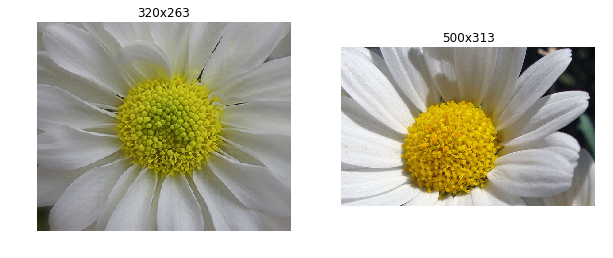

Klasa: dandelion


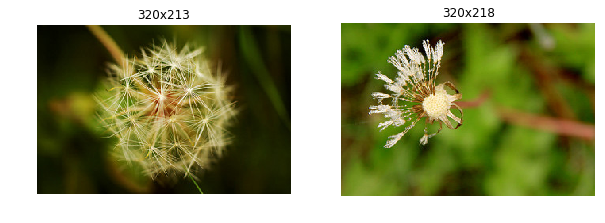

Klasa: roses


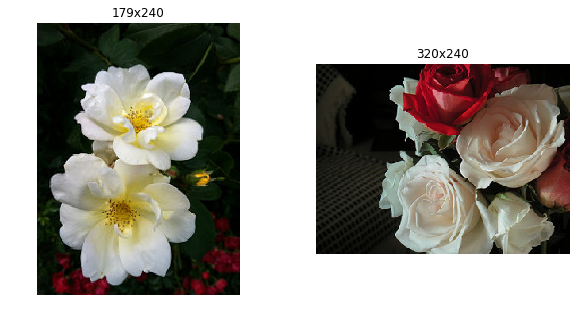

Klasa: sunflowers


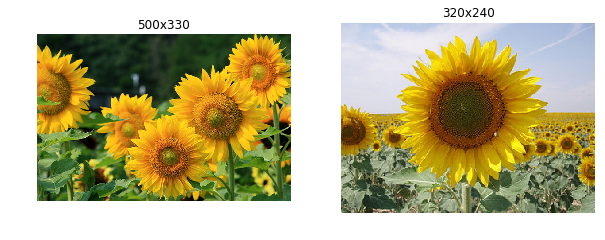

Klasa: tulips


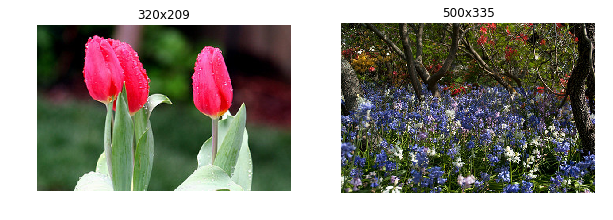

In [51]:
import matplotlib.image as mpimg

n_examples_per_class = 2

for flower_class in flower_classes:
    print("Klasa:", flower_class)
    plt.figure(figsize=(10,5))
    for index, example_image_path in enumerate(image_paths[flower_class][:n_examples_per_class]):
        example_image = mpimg.imread(example_image_path)[:, :, :channels]
        plt.subplot(100 + n_examples_per_class * 10 + index + 1)
        plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
        plt.imshow(example_image)
        plt.axis("off")
    plt.show()

Zwróć uwagę, że rozmiary obrazów mogą się różnić między sobą, a także, że zadanie jest w niektórych przypadkach bardzo trudne (np. drugie zdjęcie tulipana).

### 9.2.
Ćwiczenie: stwórz funkcję wstępnej obróbki obrazów, która będzie zmieniać ich rozmiar i przycinać do rozmiaru 299 × 299 pikseli oraz dodawała elementy losowe w celu dogenerowania danych.


Najpierw wprowadźmy implementację za pomocą modułów NumPy i SciPy:

* wykorzystamy podstawową funkcjonalność biblioteki NumPy do przycinania obrazu,
* funkcja `fliplr()` posłuży do obrócenia obrazu w poziomie (z 50-procentowym prawdopodobieństwem),
* natomiast funkcja `imresize()` modułu SciPy wprowadza możliwość przybliżania,
  * zwróć uwagę, że funkcja `imresize()` bazuje na bibliotece PIL (Python Image Library).

Więcej funkcji przetwarzania obrazów (np. obracanie) znajdziesz w [dokumentacji modułu SciPy](https://docs.scipy.org/doc/scipy-0.19.0/reference/ndimage.html) lub [na tej sympatycznej stronie](http://www.scipy-lectures.org/advanced/image_processing/).

In [48]:
from scipy.misc import imresize

def prepare_image(image, target_width = 299, target_height = 299, max_zoom = 0.2):
    """Losowo przybliża i przycina obraz w celu dogenerowania danych."""

    # Najpierw znajdźmy największy prostokąt ograniczający o docelowym współczynniku rozmiaru pasującym do obrazu
    height = image.shape[0]
    width = image.shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = width if crop_vertically else int(height * target_image_ratio)
    crop_height = int(width / target_image_ratio) if crop_vertically else height
        
    # Zmniejszmy teraz ten prostokąt ograniczający o losowy współczynnik (dzieląc wymiary przez losową wartość
    # w przedziale pomiędzy 1.0 i 1.0 + `max_zoom`.
    resize_factor = np.random.rand() * max_zoom + 1.0
    crop_width = int(crop_width / resize_factor)
    crop_height = int(crop_height / resize_factor)
    
    # Możemy następnie wybrać losowy obszar rysunku dla tego prostokąta ograniczającego.
    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    x1 = x0 + crop_width
    y1 = y0 + crop_height
    
    # Przytnijmy obraz za pomocą stworzonego przez nas losowego protokąta ograniczającego. 
    image = image[y0:y1, x0:x1]

    # Obróćmy również obraz w poziomie z 50-procentowym prawdopodobieństwem.
    if np.random.rand() < 0.5:
        image = np.fliplr(image)

    # Dopasujmy obraz do docelowych wymiarów.
    image = imresize(image, (target_width, target_height))
    
    # Na koniec upewnijmy się, że kolory będą reprezentowane jako 32-bitowe
    # wartości zmiennoprzecinkowe mieszczące się w zakresie od 0,0 do 1,0 (na razie):
    return image.astype(np.float32) / 255

Uwaga: w czasie testowania etap wstępnej obróbki obrazów powinien być maksymalnie uproszczony i pozwalający na dostarczanie obrazów do sieci neuronowej. Możesz chcieć zmodyfikować powyższą funkcję poprzez dodanie parametru `training`: w przypadku wartości `False` wstępne przetwarzanie powinno być ograniczone do minimum (tj. należy unikać obracania obrazu, przeprowadzać jedynie niezbędne przycinanie obrazu, a także zachowywać środek obrazu).

Sprawdźmy rezultaty na następującym obrazie:

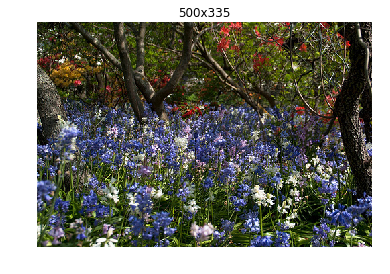

In [49]:
plt.figure(figsize=(6, 8))
plt.imshow(example_image)
plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
plt.axis("off")
plt.show()

Proszę bardzo:

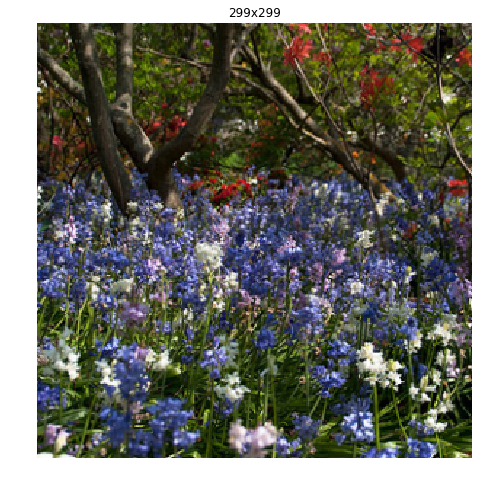

In [50]:
prepared_image = prepare_image(example_image)

plt.figure(figsize=(8, 8))
plt.imshow(prepared_image)
plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
plt.axis("off")
plt.show()

Przyjrzyjmy się teraz kilku innym losowym obrazom wygeneorwanym na podstawie tego samego oryginału:

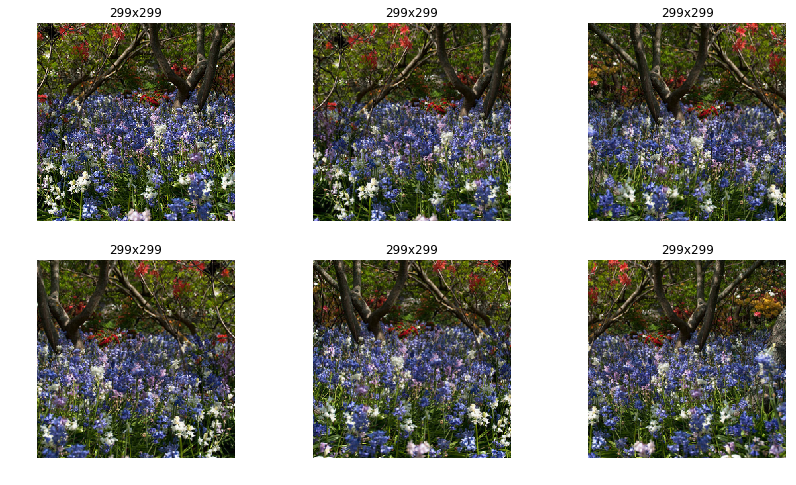

In [51]:
rows, cols = 2, 3

plt.figure(figsize=(14, 8))
for row in range(rows):
    for col in range(cols):
        prepared_image = prepare_image(example_image)
        plt.subplot(rows, cols, row * cols + col + 1)
        plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
        plt.imshow(prepared_image)
        plt.axis("off")
plt.show()

Całkiem nieźle!

Możemy ewentualnie zaimplementować etap obróbki wstępnej bezpośrednio w module TensorFlow za pomocą funkcji umieszczonych w module `tf.image` (pełną listę znajdziesz w [dokumentacji interfejsu API](https://www.tensorflow.org/api_docs/python/)). Jak widać, funkcja ta bardzo przypomina funkcję użytą powyżej; różnica polega na tym, że niniejsza funkcja nie przeprowadza przekształceń obrazu bezpośrednio, lecz tworzy zestaw operacji TensorFlow, które *będą* przeprowadzać transformację w trakcie działania grafu.

In [52]:
def prepare_image_with_tensorflow(image, target_width = 299, target_height = 299, max_zoom = 0.2):
     """Losowo przybliża i przycina obraz w celu dogenerowania danych."""

    # Najpierw znajdźmy największy prostokąt ograniczający o docelowym współczynniku rozmiaru pasującym do obrazu
    image_shape = tf.cast(tf.shape(image), tf.float32)
    height = image_shape[0]
    width = image_shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = tf.cond(crop_vertically,
                         lambda: width,
                         lambda: height * target_image_ratio)
    crop_height = tf.cond(crop_vertically,
                          lambda: width / target_image_ratio,
                          lambda: height)

    # Zmniejszmy teraz ten prostokąt ograniczający o losowy współczynnik (dzieląc wymiary przez losową wartość
    # w przedziale pomiędzy 1.0 i 1.0 + `max_zoom`.
    resize_factor = tf.random_uniform(shape=[], minval=1.0, maxval=1.0 + max_zoom)
    crop_width = tf.cast(crop_width / resize_factor, tf.int32)
    crop_height = tf.cast(crop_height / resize_factor, tf.int32)
    box_size = tf.stack([crop_height, crop_width, 3])   # 3 = liczba kanałów

    # Przytnijmy obraz za pomocą stworzonego przez nas losowego protokąta ograniczającego.
    image = tf.random_crop(image, box_size)

    # Obróćmy również obraz w poziomie z 50-procentowym prawdopodobieństwem.
    image = tf.image.random_flip_left_right(image)

    # Funkcja resize_bilinear wymaga czterowymiarowego tensora (grupy obrazów),
    # dlatego musimy najpierw powiększyć liczbę wymiarów:
    image_batch = tf.expand_dims(image, 0)

    # Na koniec  Dopasujmy obraz do docelowych wymiarów. Zwróć uwagę, że funkcja ta zwraca tensor
    # przechowujące wartości typu float32.
    image_batch = tf.image.resize_bilinear(image_batch, [target_height, target_width])
    image = image_batch[0] / 255  # powraca do pojedynczego obrazu i skaluje kolory w zakresie od 0,0 do 1,0 
    return image

Przetestujmy tę funkcję!

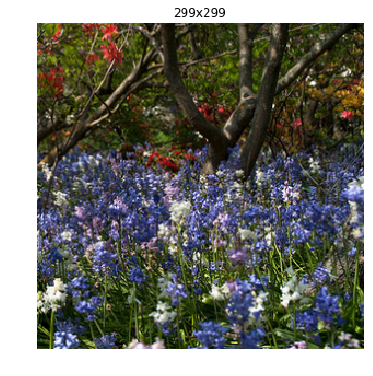

In [53]:
reset_graph()

input_image = tf.placeholder(tf.uint8, shape=[None, None, 3])
prepared_image_op = prepare_image_with_tensorflow(input_image)

with tf.Session():
    prepared_image = prepared_image_op.eval(feed_dict={input_image: example_image})
    
plt.figure(figsize=(6, 6))
plt.imshow(prepared_image)
plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
plt.axis("off")
plt.show()

Wygląda doskonale!

### 9.3.
Ćwiczenie: wykorzystaj gotowy model Inception v3 z poprzedniego ćwiczenia, zamroź wszystkie warstwy aż do warstwy ograniczającej (ostatniej warstwy przed warstwą wyjściową), a następnie zastąp warstwę wyjściową liczbą wyjść odpowiednią dla Twojego zadania klasyfikacji (np. zbiór danych ze zdjęciami kwiatów ma pięć wzajemnie wykluczających się klas, dlatego warstwa wyjściowa musi zawierać 5 neuronów i wykorzystywać funkcję aktywacji softmax)..


Zacznijmy od ponownego przygotowania grafu Inception v3. Tym razem użyjemy węzła zastępczego `training`, za pomocą którego będziemy informować moduł TensorFlow, czy sieć jest uczona lub nie (jest to informacja wymagana przez takie operacje, jak porzucanie lub normalizacja wsadowa).

In [54]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

reset_graph()

X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")
training = tf.placeholder_with_default(False, shape=[])
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=training)

inception_saver = tf.train.Saver()

Teraz musimy znaleźć punkt grafu, do którego należy podłączyć nową warstwę wyjściową. Powinna być nim warstwa znajdująca się tuż przed bieżącą warstwą wyjściową. Jednym ze sposób określenia tego miejsca jest sprawdzenie danych dostarczanych do wejść warstwy wyjściowych:  

In [55]:
logits.op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Conv2d_1c_1x1/BiasAdd:0' shape=(?, 1, 1, 1001) dtype=float32>

Nie, jest to część warstwy wyjściowej (dodająca obciążenia). Idźmy dalej w stronę początku grafu:

In [56]:
logits.op.inputs[0].op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Conv2d_1c_1x1/convolution:0' shape=(?, 1, 1, 1001) dtype=float32>

To jest także część warstwy wyjściowej - ostatnia warstwa modułu incepcyjnego (jeśli nie masz pewności, możesz zwizualizować graf w aplikacji TensorBoard). Cofnijmy się jeszcze bardziej wzdłuż grafu:

In [57]:
logits.op.inputs[0].op.inputs[0].op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Dropout_1b/cond/Merge:0' shape=(?, 1, 1, 2048) dtype=float32>

Aha! Jesteśmy w domu; oto nasze wyjście warstwy porzucania. Jest to ostatnia warstwa przed warstwą wyjściową w sieci Inception v3, zatem tutaj możemy dobudować naszą własną warstwę wyjściową. Zauważ, że istnieje w rzeczywistości prostszy sposób odnalezienia tego miejsca: funkcja `inception_v3()` zwraca słownik zawierający punkty końcowe:

In [58]:
end_points

{'AuxLogits': <tf.Tensor 'InceptionV3/AuxLogits/SpatialSqueeze:0' shape=(?, 1001) dtype=float32>,
 'Conv2d_1a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_1a_3x3/Relu:0' shape=(?, 149, 149, 32) dtype=float32>,
 'Conv2d_2a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2a_3x3/Relu:0' shape=(?, 147, 147, 32) dtype=float32>,
 'Conv2d_2b_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2b_3x3/Relu:0' shape=(?, 147, 147, 64) dtype=float32>,
 'Conv2d_3b_1x1': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_3b_1x1/Relu:0' shape=(?, 73, 73, 80) dtype=float32>,
 'Conv2d_4a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_4a_3x3/Relu:0' shape=(?, 71, 71, 192) dtype=float32>,
 'Logits': <tf.Tensor 'InceptionV3/Logits/SpatialSqueeze:0' shape=(?, 1001) dtype=float32>,
 'MaxPool_3a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_3a_3x3/MaxPool:0' shape=(?, 73, 73, 64) dtype=float32>,
 'MaxPool_5a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_5a_3x3/MaxPool:0' shape=(?, 35, 35, 192) dtype=floa

Jak widać, punkt końcowy `"PreLogits"` jest dokładnie tym, czego potrzebujemy:

In [59]:
end_points["PreLogits"]

<tf.Tensor 'InceptionV3/Logits/Dropout_1b/cond/Merge:0' shape=(?, 1, 1, 2048) dtype=float32>

Możemy zrezygnować z drugiego i trzeciego wymiaru za pomocą funkcji `tf.squeeze()`:

In [60]:
prelogits = tf.squeeze(end_points["PreLogits"], axis=[1, 2])

Teraz możemy dodać ostatnią w pełni połączoną warstwę na wierzchu tej warstwy:

In [61]:
n_outputs = len(flower_classes)

with tf.name_scope("nowa_warstwa_wyjsciowa"):
    flower_logits = tf.layers.dense(prelogits, n_outputs, name="kwiaty_logity")
    Y_proba = tf.nn.softmax(flower_logits, name="Y_prawd")

Na koniec musimy wprowadzić standardowe dodatki:

* węzeł zastępczy dla etykiet (`y`),
* funkcję straty, w tym przypadku entropię krzyżową, stanowiącą standard w zadaniach klasyfikacyjnych,
* optymalizator, za pomocą którego stworzymy operację uczenia minimalizującą funkcję kosztu,
* dwie operacje mierzące dokładność modelu,
* a także inicjator i obiekt `Saver`.

Należy jednak zwrócić uwagę na pewien istotny szczegół: chcemy trenować tylko warstwę wyjściową (wszystkie pozostałe muszą być zamrożone), dlatego musimy przekazać listę trenowanych zmiennych metodzie `minimize()` optymalizatora:

In [62]:
y = tf.placeholder(tf.int32, shape=[None])

with tf.name_scope("uczenie"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=flower_logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    flower_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="kwiaty_logity")
    training_op = optimizer.minimize(loss, var_list=flower_vars)

with tf.name_scope("ocena"):
    correct = tf.nn.in_top_k(flower_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("inicjacja_i_zapisywanie"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver() 

In [63]:
[v.name for v in flower_vars]

['flower_logits/kernel:0', 'flower_logits/bias:0']

Zwróć uwagę, że stworzyliśmy węzeł `inception_saver` jeszcze przed dodaniem nowej warstwy wyjściowej: wykorzystamy go do odtworzenia stanu gotowego modelu, dlatego nie chcemy, aby próbował odtwarzać nowe zmienne (mógłby po prostu poinformować nas, że nie zna nowych zmiennych). Drugi obiekt `saver` zostanie użyty do zapisania ostatecznego modelu, włącznie z gotowymi i nowymi zmiennymi.

### 9.4.
Ćwiczenie: Rozdziel zestaw danych na podzbiory uczący i testowy. Wytrenuj model na zbiorze uczącym i oceń jego wydajność za pomocą zbioru testowego.


Na początek chcemy przekształcić wartości klas z ciągów znaków do postaci stałoprzecinkowej:

In [64]:
flower_class_ids = {flower_class: index for index, flower_class in enumerate(flower_classes)}
flower_class_ids

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

Łatwiej nam będzie przetasować zbiór danych, jeśli będzie on reprezentowany jako lista par ścieżka/klasa:

In [65]:
flower_paths_and_classes = []
for flower_class, paths in image_paths.items():
    for path in paths:
        flower_paths_and_classes.append((path, flower_class_ids[flower_class]))

Przetasujmy następnie zbiór danych i rozdzielmy go na podzbiory uczący i testowy:

In [66]:
test_ratio = 0.2
train_size = int(len(flower_paths_and_classes) * (1 - test_ratio))

np.random.shuffle(flower_paths_and_classes)

flower_paths_and_classes_train = flower_paths_and_classes[:train_size]
flower_paths_and_classes_test = flower_paths_and_classes[train_size:]

Przyjrzyjmy się trzem pierwszym próbkom w zbiorze uczącym:

In [67]:
flower_paths_and_classes_train[:3]

[('datasets/flowers/flower_photos/roses/1788484468_f73afa6c32_n.jpg', 2),
 ('datasets/flowers/flower_photos/sunflowers/3865206264_5d81584bba.jpg', 3),
 ('datasets/flowers/flower_photos/daisy/5944315415_2be8abeb2f_m.jpg', 0)]

Teraz potrzebujemy również funkcji wstępnie przetwarzającej zbiór obrazów. Przyda nam się ona do wstępnej obróki zbioru testowego oraz do tworzenia mini-grup podczas uczenia. Dla uproszczenia skorzystamy z implementacji NumPy/SciPy:

In [68]:
from random import sample

def prepare_batch(flower_paths_and_classes, batch_size):
    batch_paths_and_classes = sample(flower_paths_and_classes, batch_size)
    images = [mpimg.imread(path)[:, :, :channels] for path, labels in batch_paths_and_classes]
    prepared_images = [prepare_image(image) for image in images]
    X_batch = 2 * np.stack(prepared_images) - 1 # Model Inception spodziewa się wartości kolorów w zakresie od -1 do 1
    y_batch = np.array([labels for path, labels in batch_paths_and_classes], dtype=np.int32)
    return X_batch, y_batch

In [69]:
X_batch, y_batch = prepare_batch(flower_paths_and_classes_train, batch_size=4)

In [70]:
X_batch.shape

(4, 299, 299, 3)

In [71]:
X_batch.dtype

dtype('float32')

In [72]:
y_batch.shape

(4,)

In [73]:
y_batch.dtype

dtype('int32')

Wygląda to dobrze. Użyjmy teraz tej funkcji do przygotowania zbioru testowego:

In [74]:
X_test, y_test = prepare_batch(flower_paths_and_classes_test, batch_size=len(flower_paths_and_classes_test))

In [75]:
X_test.shape

(734, 299, 299, 3)

Moglibyśmy w ten sam sposób przygotować zbiór uczący, ale generowany byłby tylko jeden wariant każdego obrazu. Zamiast tego lepiej generować grupy uczące na bieżąco w czasie uczenia, dzięki czemu wykorzystamy pełnię możliwości dogenerowania danych, gdyż zostanie wygenerowanych wiele wariantów danego obrazu.

Jesteśmy już gotowi do wyuczenia sieci (dokładniej zaś mówiąc - dopiero co dołączonej warstwy wyjściowej, ponieważ wszystkie pozostałe warstwy są zamrożone). Proces ten może zająć (bardzo) długi czas.

In [76]:
X_test, y_test = prepare_batch(flower_paths_and_classes_test, batch_size=len(flower_paths_and_classes_test))

In [77]:
X_test.shape

(734, 299, 299, 3)

In [78]:
n_epochs = 10
batch_size = 40
n_iterations_per_epoch = len(flower_paths_and_classes_train) // batch_size

with tf.Session() as sess:
    init.run()
    inception_saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)

    for epoch in range(n_epochs):
        print("Epoka", epoch, end="")
        for iteration in range(n_iterations_per_epoch):
            print(".", end="")
            X_batch, y_batch = prepare_batch(flower_paths_and_classes_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})

        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("  Dokładność dla zbioru uczącego:", acc_train)

        save_path = saver.save(sess, "./moj_model_kwiaty")

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt
Epoch 0.........................................................................  Train accuracy: 0.625
Epoch 1.........................................................................  Train accuracy: 0.625
Epoch 2.........................................................................  Train accuracy: 0.75
Epoch 3.........................................................................  Train accuracy: 0.55
Epoch 4.........................................................................  Train accuracy: 0.65
Epoch 5.........................................................................  Train accuracy: 0.575
Epoch 6.........................................................................  Train accuracy: 0.7
Epoch 7.........................................................................  Train accuracy: 0.8
Epoch 8.........................................................................  Train accuracy

In [79]:
n_test_batches = 10
X_test_batches = np.array_split(X_test, n_test_batches)
y_test_batches = np.array_split(y_test, n_test_batches)

with tf.Session() as sess:
    saver.restore(sess, "./moj_model_kwiaty")

    print("Obliczanie ostatecznej dokładności dla zbioru testowego (może to zająć chwilę)...")
    acc_test = np.mean([
        accuracy.eval(feed_dict={X: X_test_batch, y: y_test_batch})
        for X_test_batch, y_test_batch in zip(X_test_batches, y_test_batches)])
    print("Dokładność dla zbioru testowego:", acc_test)

INFO:tensorflow:Restoring parameters from ./my_flowers_model
Computing final accuracy on the test set (this will take a while)...
Test accuracy: 0.705813


No dobrze, dokładność rzędu 70,58% nie jest jakaś wybitna (w rzeczywistości jest całkiem kiepska), wynik ten jednak uzyskujemy zaledwie po 10 epokach i to po zamrożeniu wszystkich warstw oprócz wyjściowej. Jeżeli masz kartę graficzną, możesz spróbować jeszcze raz i pozwolić na znacznie dłuższy trening (wykorzystując np. wczesne zatrzymywanie do określenia końca procesu). Możesz również zmodyfikować funkcję wstępnego przetwarzania obrazów po to, aby jeszcze bardziej zróżnicować dane (np. zmieniając jasność i nasycenie kolorów, czy obracając nieznacznie obraz). W przypadku tego zadania możesz osiągnąć dokładność rzędu 95%. Jeśli to za mało, w tym [znakomitym wpisie](https://kwotsin.github.io/tech/2017/02/11/transfer-learning.html) znajdziesz więcej szczegółów, dzięki którym będziesz w stanie osiągnąć dokładność 96%.

## 10.
Ćwiczenie: zapoznaj się z [samouczkiem DeepDream](https://goo.gl/4b2s6g). Jest to bardzo interesujący sposób przyswojenia sobie różnych sposobów wizualizowania wzorców wykrywanych przez głębokie sieci neuronowe, a jednocześnie generowania dzieł sztuki za pomocą uczenia głębokiego.

Po prostu pobierz notatnik i wykonuj zawarte w nim instrukcje. Aby uzyskać dodatkowy walor rozrywkowy możesz stworzyć szereg obrazów stopniowo je przybliżacją i uruchamiając algorytm DeepDream: za pomocą takiego narzędzia, jak [ffmpeg](https://ffmpeg.org/) możesz następnie stworzyć film składający się z tych obrazów. Na przykład tutaj znajdziesz stworzony przez mnie [filmik DeepDream](https://www.youtube.com/watch?v=l6i_fDg30p0)... okazuje się, że moje "dzieło" szybko zmienia się w koszmar. ;-) W internecie znajdziesz setki [podobnych filmików](https://www.youtube.com/results?search_query=+deepdream) (często znacznie bardziej artystycznych).